## 估计模型参数

In [2]:
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm  # 贝叶斯相关包，需要安装
import scipy
import scipy.stats as stats
import scipy.optimize as opt
import statsmodels.api as sm
%matplotlib inline

plt.style.use('bmh')
colors = ['#348ABD','#A60628','#7A68A6','#467821','#D55E00',
          '#CC79A7','#56B4E9','#009E73','#F0F442','#0072B2']

messages = pd.read_csv('hangout_chat_data.csv')  # 某人的聊天数据，如回复信息的速度等

**贝叶斯看待数据的思维**

假设蹲在山上数羊 12，33，20，29，20，30，18（每天数看到几只羊，得到一周的数据）

按照贝叶斯的思想，数据已经定下来了，减下来就是找到参数的概率分布

我们的数据是非负的整数，在这里我们用泊松分布来建模，泊松分布只需要μ，它描述数据的均值和方差
<img src="assets/20201128183746.png" width="30%">

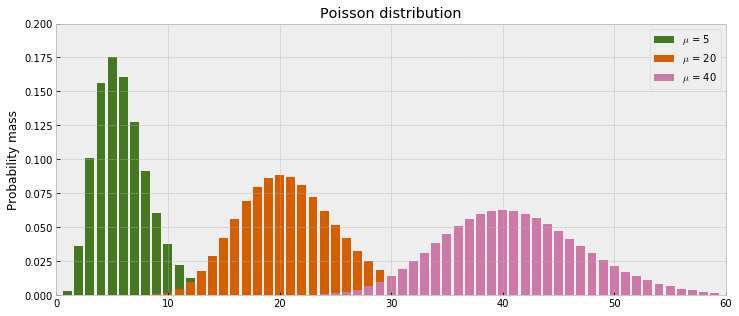

In [3]:
# 画出泊松分布的图
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
x_lim = 60
mu = [5,20,40]
for i in np.arange(x_lim):
    plt.bar(i,stats.poisson.pmf(mu[0],i),color=colors[3])
    plt.bar(i,stats.poisson.pmf(mu[1],i),color=colors[4])
    plt.bar(i,stats.poisson.pmf(mu[2],i),color=colors[5])
    
_ = ax.set_xlim(0,x_lim)
_ = ax.set_ylim(0,0.2)
_ = ax.set_ylabel('Probability mass')
_ = ax.set_title('Poisson distribution')
_ = plt.legend(['$\mu$ = %s' % mu[0], '$\mu$ = %s' % mu[1], '$\mu$ = %s' % mu[2]])

不同的mu值下的泊松分布长相

回消息的反应时间的分布情况

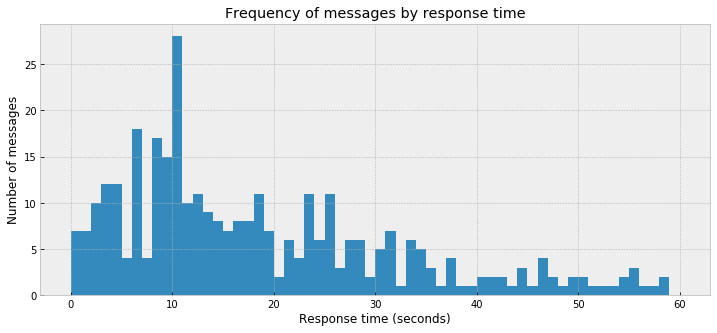

In [4]:
fig = plt.figure(figsize=(12,5))
_ = plt.title('Frequency of messages by response time')
_ = plt.xlabel('Response time (seconds)')
_ = plt.ylabel('Number of messages')
_ = plt.hist(messages['time_delay_seconds'].values,
             range=[0, 60], bins=60, histtype='stepfilled')

y轴是回复的样本个数，x轴是消息发来的回复时间。

10秒的时候回复最多

**极大似然估计求μ**

在用贝叶斯方法之前，先用最大似然估计来求解。
<ul>
    <li>poisson_logprob()根据泊松模型和参数值返回观测数据的总似然值。
    <li>opt.minimize_scalar找到最合适的取值。

In [5]:
y_obs = messages['time_delay_seconds'].values

def poisson_logprob(mu, sign=-1):
    return np.sum(sign*stats.poisson.logpmf(y_obs, mu=mu))

freq_results = opt.minimize_scalar(poisson_logprob)
%time print("The estimated value of mu is: %s" % freq_results['x'])

The estimated value of mu is: 18.2307692323807
Wall time: 996 µs


得到结果μ = 18.2307692323807，但这仅仅是一个值。

下面展示这个过程，不断爬坡的过程。

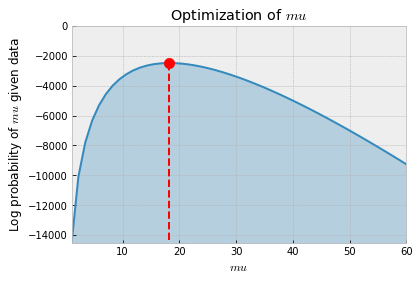

In [6]:
x = np.linspace(1, 60)
y_min = np.min([poisson_logprob(i, sign=1) for i in x])
y_max = np.max([poisson_logprob(i, sign=1) for i in x])

fig = plt.figure(figsize=(6,4))
_ = plt.plot(x, [poisson_logprob(i, sign=1) for i in x])
_ = plt.fill_between(x, [poisson_logprob(i, sign=1) for i in x], 
                     y_min, color=colors[0], alpha=0.3)

_ = plt.title('Optimization of $mu$')
_ = plt.xlabel('$mu$')
_ = plt.ylabel('Log probability of $mu$ given data')
_ = plt.vlines(freq_results['x'], y_max, y_min, colors='red', linestyles='dashed')
_ = plt.scatter(freq_results['x'], y_max, s=110, c='red', zorder=3)
_ = plt.ylim(ymin=y_min, ymax=0)
_ = plt.xlim(xmin=1, xmax=60)

代入参数后分布的样子

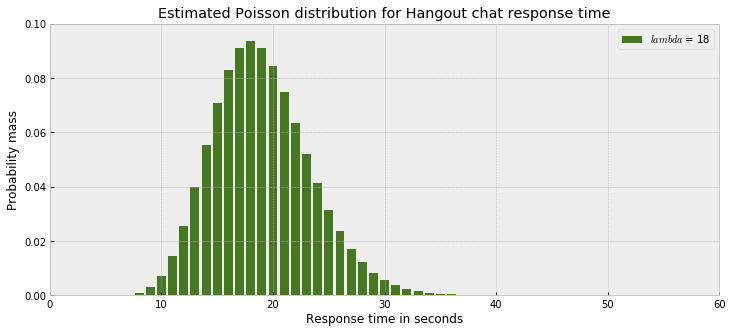

In [7]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
x_lim = 60
mu = np.int(freq_results['x'])

for i in np.arange(x_lim):
    plt.bar(i, stats.poisson.pmf(mu, i), color=colors[3])

_ = ax.set_xlim(0, x_lim)
_ = ax.set_ylim(0, 0.1)
_ = ax.set_xlabel('Response time in seconds')
_ = ax.set_ylabel('Probability mass')
_ = ax.set_title('Estimated Poisson distribution for Hangout chat response time')
_ = plt.legend(['$lambda$ = %s' % mu])

上述泊松分布模型和 μ 的估计表明，观测小于10 或大于 30 的可能性很小，绝大多数的概率分布在 10 和 30 之间。但是，这不能反映我们观测到的介于 0 到 60 之间的数据。

#### 贝叶斯方法估计μ

<img src="assets/20201128203033.png" width="30%">

<img src="assets/20201128203246.png" width="30%">

上述可解读如下（从下到上）：
<ul>
    <li>对每一个对话（i）观测计数数据（y）
    <li>数据由一个随机过程产生，我们认为可以用泊松分布模拟
    <li>泊松分布只有一个参数，介于 0 到 60 之间
    <li>均匀分布的原因在于并没有提及任何条件

**马尔可夫链蒙特卡洛方法MCMC**

贝叶斯公式的只是一个参数，但如果我们的问题涉及到多个参数呢？分布的积分就应该改成多重积分，但是难点在于我们该怎么算，MCMC采样器从先验分布中选取参数值，计算从这些参数值决定的某个分布中得到观测数据的可能性。这个计算可以作为MCMC采样器的导引。从参数的先验分布中选取值，然后计算给定数据条件下这些参数值可能性——导引采样器到更高概率的区域。与上面讨论的频率论优化技术在概念上有相似之处，MCMC采样器向可能性最高的区域运动。但是，贝叶斯方法不关心寻找绝对最大值，而是遍历和收集概率最高区域附近的样本。所有收集到的样本都可认为是一个可信的参数

**蒙特卡洛方法**

是一系列应用非常广泛的算法，其思想是通过随机采样来计算或模拟给定过程。尽管很多问题都难以求解甚至没办法用公式表达，但我们可以通过采样或者模拟来有效地研究

统计模拟中有一个重要的问题就是给定一个概率分布p(x)，如何在计算机中生成它的样本。其基本思想是通过大量取近似得到想要的答案。有一个经典的试验就是计算圆周率，在一个边上为1的正方形中画一个内切圆，现在在正方形内产生大量随机数，最后我们只需要计算圆内点的个数比上总体的个数，便得到了圆周率的值。

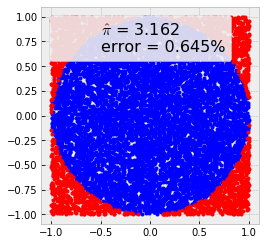

In [8]:
# 每次结果会不一样，样本越多必然也会越准确，可以尝试把N值改小改大
N = 10000

x, y = np.random.uniform(-1,1,size=(2,N))
inside = (x**2 + y**2) <= 1
pi = inside.sum()* 4 / N
error = abs((pi - np.pi) / pi) * 100

outside = np.invert(inside)

plt.plot(x[inside], y[inside], 'b.')
plt.plot(x[outside], y[outside], 'r.')
plt.plot(0,0,label='$\hat \pi$ = {:4.3f}\nerror = {:4.3f}%'.format(pi, error), alpha=0)
plt.axis('square')
plt.legend(frameon=True, framealpha=0.9,fontsize=16)

### PYMC3概述
**马氏链的平稳性**

对于先验分布，如果能找到一个转移矩阵，那么在n步之后就会收敛到一个平稳分布，而这个分布就是我们要的后验分布。得到平稳分布后，根据平稳性，继续乘上这个转移概率矩阵，平稳分布依然不会改变，所以我们就从得到平稳分布开始每次对其进行抽样。

<img src="assets/20201128211430.png" width="30%">
<img src="assets/20201128211519.png" width="30%">
越到后面几代人，值越平稳不变

In [27]:
with pm.Model() as model:  # 构造模型
    mu = pm.Uniform('mu', lower=0, upper=60)  # 指定一个均值，服从正态分布且是0-60之间
    # 指定泊松分布，并把数据放进去
    likelihood = pm.Poisson('likelihood', mu=mu, observed=messages['time_delay_seconds'].values)

    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(2000, step, start=start, progressbar=True)

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [mu]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 64 seconds.
The number of effective samples is smaller than 25% for some parameters.


上面的代码通过遍历 μ 的后验分布的高概率区域，收集了 200,000 个 μ 的可信样本。下图（左）显示这些值的分布，平均值与频率论的估值（红线）几乎一样。但是，我们同时也得到了不确定度，μ 值介于 17 到 19 之间都是可信的。我们稍后会看到这个不确定度很有价值。

<img src="assets/20201128211719.png" width="50%">

### PyMC3概述
PyMC3是一个用于概率编程的Python库，提供了一套非常简洁直观的语法，非常接近统计学中描述概率模型的语法，可读性很高。其核心计算部分基于NumPy和Theano。Theano是用于深度学习的Python库，可以高效地定义、优化和求解多维数组的数学表达式。

In [10]:
# 定义抛硬币问题，假设知道真实的参数θ，用theta_real来表示
np.random.seed(1)
n_experiments = 100
theta_real = 0.35
data = stats.bernoulli.rvs(p=theta_real, size=n_experiments)
print(data)

[0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 1 0 1 1 1 0 0 0 1 0 0 1 0 1 0 1
 1 0 1 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 1 0 0 1
 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 1 0 0 0]


现在有了数据，需要再指定模型。前面我们通过似然和先验的概率分布完成。对于似然可以用二项分布来描述，对于先验可以用参数为α=β=1的beta分布描述。这个beta分布再[0,1]区间内均匀分布是一样的。可以用数学表达式描述如下：
<img src="assets/20201128213453.png" width="30%">

In [11]:
with pm.Model() as our_first_model:  # 构造模型
    theta = pm.Beta('theta', alpha=1, beta=1)  # 指定先验
    y = pm.Bernoulli('y', p=theta, observed=data)  # 用和先验相同的语法描述似然，唯一不同的是用observed变量传递观测到的数据

    start = pm.find_MAP()  # 返回最大后验，为采样方法提供一个初始点
    step = pm.Metropolis()  # 定义采样方法，用Metropolis-Hastings算法，PyMC3也会根据不同参数的特征自动赋予一个采样器
    trace = pm.sample(1000, step=step, start=start)  # 执行推断，其中第一个参数是采样次数，2、3分别是采样方法和初始点

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.
The number of effective samples is smaller than 25% for some parameters.


**诊断采样过程**

现在我们根据有限数量的样本对后验做出近似，接下来就是坚持我们的近似是否合理。我们可以做一些测试，可视化、定量等。这些测试会尝试从样本中发现问题，但并不能证明我们得到的分布是正确的，我们只能提供证据证明样本看起来是合理的。如果我们通过样本发现问题，解决办法有如下几种。
<ul>
    <li>增加样本次数。
    <li>从样本链的前面部分去掉一定数量的样本，称为老化（Burn-in）
    <li>重新参数化模型，也就是换一种不同但却等价的方式描述模型。
</ul>

**收敛性**

通常，我们要做的第一件事就是查看结果长什么样，利用traceplot函数

D:\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
D:\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\traceplot.py:214: UserWarning: A valid var_name should be provided, found {'t'} expected from {'theta'}
  invalid_var_names, all_var_names


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002ED583FFB70>,
      dtype=object)

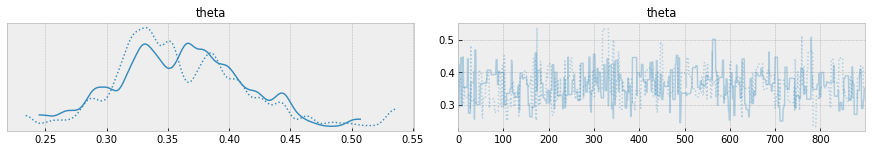

In [12]:
burnin = 100  # 指定老化，前100个
chain = trace[burnin:]
pm.traceplot(chain, lines={'theta':theta_real})

对于未观測到的变量，我们得到了两幅图。左图是一个核密度估计( Kernel Density Estimation,KDE)图。右图描绘的是每一步采样过程中得到的采样值。注意图中红色的线表示变量 theta real的值。

在得到这些图之后，我们需要观察什么呢? 首先，KDE图看起来应该是光滑的曲线。通常，随着数据的增加，根据中心极限定理，参数的分布会趋近于高斯分布。右侧的图看起来应该像白噪声，也就是说有很好的混合度( mixing)，我们看不到任何可以识别的模式，也看不到向上或者向下的曲线，相反，我们希望看到曲线在某个值附近震荡。对于多峰分布或者离散分布，我们希望曲线不要在某个值或区域停留过多时间，我们希望看到采样值在多个区间自由移动。此外，我们希望迹表现出稳定的相似性，也就是说，前10%看起来跟后50%或者10%差不多。再次强调，我们不希望看到规律的模式,相反我们期望看到的是噪声。下图展示了一些迹呈现较好混合度(右侧)与较差混合度(左侧)的对比。

<img src="assets/20201128215037.png" width="50%">

如果迹的前面部分跟其他部分看起来不太一样，那就意味着需要进行老化处理，如果其他部分没有呈现稳定的相似性或者可以看到某种模式，那这意味着需要更多的采样，或者需要更换采样方法或者参数化方法。对于一些复杂的模型,我们可能需要结合使用前面所有的策略。

### 模型决策

一种定量地检测收敛性的方法是 Gelman- Rubin检验。该检验的思想是比较不同迹之间的差异和迹内部的差异，因此，需要多组迹来进行该检验。理想状态下，我们希望得到R=1，根据经验，如果得到的值低于1.1，那么可以认为是收敛的了，更高的值则意味着没有收敛。

pycm3模块中gelman_rubin 因为Gelman＆Rubin（1992）论文是BDA3方程，与gelman_rubin的BDA2不同，所以改名了，且换了模块，绘图和诊断都迁移到arviz了

In [20]:
import arviz
arviz.rhat(chain)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    theta    float64 1.011

函数 summary提供了对后验的文字描述，它可以提供后验的均值、标准差和HPD区间(最大后验密度可信区间)

In [14]:
pm.summary(chain)

D:\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
theta  0.36  0.05   0.269    0.447      0.003    0.002     309.0   299.0   

       ess_bulk  ess_tail  r_hat  
theta     318.0     267.0   1.01

其中,返回值之一是 mc_error，这是对采样引入误差的估计值，该值考虑的是所有的采样值并非真的彼此独立。 mc error是迹中不同块的均值的标准差，每一块是迹中的一部分。

**自相关**

最理想的采样应该不会是自相关的，也就是说，某一点的值应该与其他点的值是相互独立的。由于参数之间的相互依赖关系，可能模型会导致更多的自相关采样。PyMC3有一个很方便的函数用来描述自相关。

D:\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002444A3F0518>,
      dtype=object)

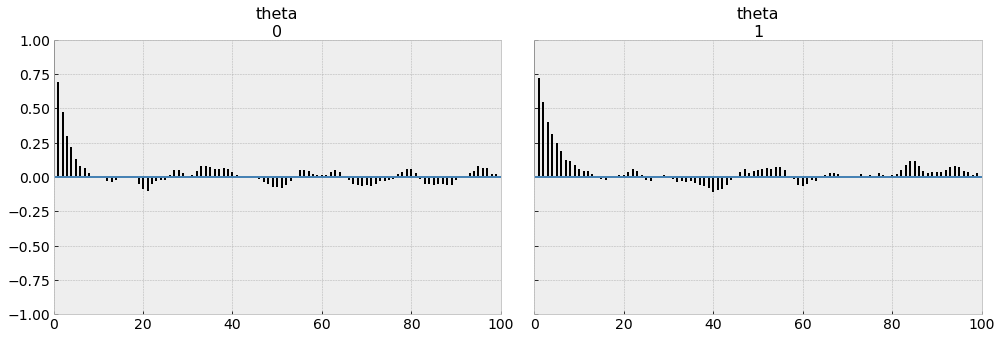

In [48]:
pm.autocorrplot(chain)

该图显示了采样值与相邻连续点(最多100个)之间的平均相关性。理想状态下，我们不会看到自相关性，实际中我们希望看到自相关性降低到较低水平。参数越自相关，要达到指定精度的采样次数就需要越多，也就是说，自相关性不利于降低采样次数。

**有效采样大小**

一个有自相关性的采样要比没有自相关性的采样所包含的信息量更少，因此，给定采样大小和采样的自相关性之后，我们可以尝试估计出该采样的大小为多少时，该采样没有自相关性而且包含的信息量不变，该值称为有效采样大小。理想情况下，两个值是一模一样的；二者越接近，我们的采样效率越高。有效采样大小可以作为我们的一个参考，如果我们想要估计出一个分布的均值，我们需要的最小采样数至少为100；如果想要估计出依赖于尾部分布的量，比如可信区间的边界，那么我们可能需要1000到10000次采样。

In [26]:
pm.effective_n(chain)['theta']  # 可以查看有效采样数644.0，这个api已经迁移，至今我都没找到替代的

AttributeError: module 'pymc3' has no attribute 'effective_n'

显然，提高采样效率的一个方法是换一个更好的采样方法；另一个办法是转换数据或者对模型重新设计参数。

目前为止，所有的诊断测试都是经验性而非绝对的。实际使用中，我们会先运行一些测试，如果看起来没什么问题，我们就继续往下分析。如果发现了一些问题，就需要回过头解决它们，这也是建模过程的一部分。要知道，进行收敛性检查并非贝叶斯理论的一部分，由于我们是用数值的方式在计算后验，因而这只是贝叶斯实践过程中的一部分.

**总结后验**

我们已经知道，贝叶斯分析的结果是后验分布，其包含了在已有数据和模型下，参数的所有信息。我们可以使用PyMc3中的 plot_posterior函数对后验分布进行可视化总结，这个函数的核心参数是一个PyMc3的迹和或者一个 Numpy的数组，默认情况下，该函数会画出参数的直方图以及分布的均值,此外图像的底端还有个黑色的粗线用来表示95% HPD区间。

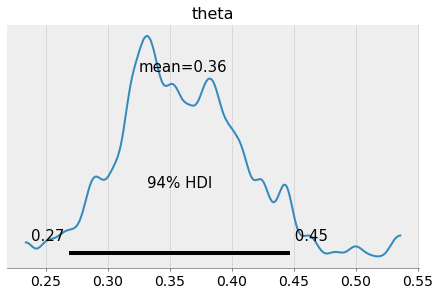

In [17]:
pm.plot_posterior(chain)

**基于后验的决策**

有时候，仅仅描述后验还不够，我们还需要根据推断结果做决策，即将连续的估计值收敛到一个二值化结果上: 是或不是、受污染了还是安全的等等。回到拋硬币问题上，我们需要回答硬币是不是公平的。一枚公平的硬币是指θ的值为0.5，严格来说，出现这种情况的概率是0，因而，实际中我们会对定义稍稍放松，假如枚硬币的θ值在0.5左右，我们就认为这枚硬币是公平的。这里左右"的具体含义依赖于具体的问题，并没有一个满足所有问题的普适准则。因此决策也是偏主观的，我们的任务就是根据我们的目标做出最可能的决策。

直观上，一个明智的做法是将HPD区间与我们感兴趣的值进行比较，在我们的例子中，该值是0.5。前面的图中可以看出HPD的范围是006~0.71，包含05这个值，不过根据后验分布来看，硬币似乎倾向于反面朝上，我们无法就此裁定一个硬币是公平的。或许,我们需要收集更多的数据来降低数据的分散程度，从而得到一个更确定的决策；又或者是因为我们漏掉了某些关键信息,以至我们没能找到更完备的先验。

**实用等价区间**
基于后验做决策的一种方案是实用等价区间( Region Of Practical Equivalence,ROPE)，其实就是在感兴趣值附近的一个区间，例如我们可以说[045,0.55]是0.5的一个实用性等价区间。同样，R◎PE是根据实际情况决定的。接下来我们可以将ROPE与HPD对比，结果至少有以下3种情况：
<ul>
    <li>RPE与HPD区间没有重叠,因此我们可以说硬币是不公平的。
    <li>ROPE包含整个HPD区间,我们可以认为硬币是公平的。
    <li>ROPE与HPD区间部分重叠,此时我们不能判断硬币是否公平
</ul>

当然，如果选择区间[0,1]作为ROPE，那么不管结果怎样我们都会说这枚硬币是公平的，不过恐怕没人会同意我们对ROPE的定义。 plot_posterio函数可以用来画ROPE。从图中可以看到,ROPE是一段较宽的半透明的红色线段，同时上面有两个数值表示ROPE的两个端点。

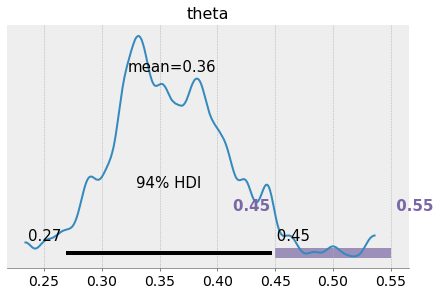

In [18]:
pm.plot_posterior(chain, rope=[0.45,0.55])